## 重新审视过拟合
当⾯对更多的特征⽽样本不⾜时，线性模型往往会过拟合。相反，当给出更多样本⽽不是特征，通常线性模型不会过拟合。不幸的是，线性模型泛化的可靠性是有代价的。简单地说，线性模型没有考虑到特征之间的交互作⽤。对于每个特征，线性模型必须指定正的或负的权重，⽽忽略其他特征。  

泛化性和灵活性之间的这种基本权衡被描述为偏差-⽅差权衡（bias-variance tradeoff）。线性模型有很⾼的偏差：它们只能表⽰⼀⼩类函数。然⽽，这些模型的⽅差很低：它们在不同的随机数据样本上可以得出相似的结果。  

深度神经⽹络位于偏差-⽅差谱的另⼀端。与线性模型不同，神经⽹络并不局限于单独查看每个特征，⽽是学习特征之间的交互。即使我们有⽐特征多得多的样本，深度神经⽹络也有可能过拟合。  

深度⽹络的泛化性质令⼈费解，⽽这种泛化性质的数学基础仍然是悬⽽未决的研究问题。



## 扰动的稳健性
经典泛化理论认为，为了缩⼩训练和测试性能之间的差距，应该以简单的模型为⽬标。简单性的另⼀个⻆度是平滑性，即函数不应该对其输⼊的微⼩变化敏感。  

在2014年，斯⾥⽡斯塔⽡等⼈ (Srivastava et al., 2014) 就如何将毕晓普的想法应⽤于⽹络的内部层提出了⼀个想法：在训练过程中，他们建议在计算后续层之前向⽹络的每⼀层注⼊噪声。因为当训练⼀个有多层的深层⽹络时，注⼊噪声只会在输⼊-输出映射上增强平滑性。  

这个想法被称为暂退法（dropout）。暂退法在前向传播过程中，计算每⼀内部层的同时注⼊噪声，这已经成为训练神经⽹络的常⽤技术。这种⽅法之所以被称为暂退法，因为我们从表⾯上看是在训练过程中丢弃（dropout）⼀些神经元。在整个训练过程的每⼀次迭代中，标准暂退法包括在计算下⼀层之前将当前层中的⼀些节点置零。  

关键的挑战就是如何注⼊这种噪声。⼀种想法是以⼀种⽆偏向（unbiased）的⽅式注⼊噪声。这样在固定住其他层时，每⼀层的期望值等于没有噪⾳时的值。  
 
在标准暂退法正则化中，通过按保留（未丢弃）的节点的分数进⾏规范化来消除每⼀层的偏差。换⾔之，每个中间活性值h以暂退概率p由随机变量h′替换，如下所⽰：  
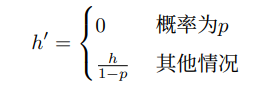  
根据此模型的设计，其期望值保持不变，即E[h′] = h。




## 实践中的暂退法
下图中带有1个隐藏层和5个隐藏单元的多层感知机。当我们将暂退法应⽤到隐藏层，以p的概率将隐藏单元置为零时，结果可以看作⼀个只包含原始神经元⼦集的⽹络。⽐如在图中删除了h2和h5，因此输出的计算不再依赖于h2或h5，并且它们各⾃的梯度在执⾏反向传播时也会消失。这样，输出层的计算不能过度依赖于h1, . . . , h5的任何⼀个元素。  
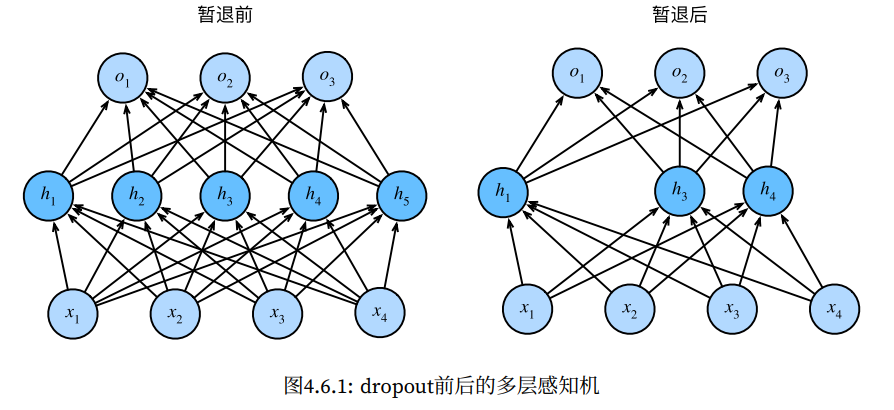  

通常，我们在测试时不⽤暂退法。给定⼀个训练好的模型和⼀个新的样本，我们不会丢弃任何节点，因此不需要标准化。

## 从零开始实现
要实现单层的暂退法函数，我们从均匀分布U[0, 1]中抽取样本，样本数与这层神经⽹络的维度⼀致。然后我们保留那些对应样本⼤于p的节点，把剩下的丢弃。  
该函数以dropout的概率丢弃张量输⼊X中的元素，如上所述重新缩放剩余部分：将剩余部分除以1.0-dropout。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)


In [3]:
#测试dropout_layer函数。我们将输⼊X通过暂退法操作，暂退概率分别为0、0.5和1。
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
#暂退概率为0时，所有元素被保留
print(dropout_layer(X, 0.))
#暂退概率为0.5时，部分元素被保留
print(dropout_layer(X, 0.5))
#暂退概率为1时，所有元素被丢弃
print(dropout_layer(X, 1.))


tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  6.,  8., 10., 12.,  0.],
        [16., 18., 20., 22., 24.,  0., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


## 定义模型参数
引⼊的Fashion-MNIST数据集。我们定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元。

In [4]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### 定义模型
可以将暂退法应⽤于每个隐藏层的输出（在激活函数之后），并且可以为每⼀层分别设置暂退概率：常⻅的技巧是在靠近输⼊层的地⽅设置较低的暂退概率。下⾯的模型将第⼀个和第⼆个隐藏层的暂退概率分别设置为0.2和0.5，并且暂退法只在训练期间有效。

In [5]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        #定义一个两个隐藏层的多层感知机
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使⽤dropout
        if self.training == True:
            # 在第⼀个全连接层之后添加⼀个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第⼆个全连接层之后添加⼀个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out
    
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### 训练和测试


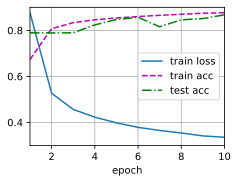

In [7]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 简介实现
对于深度学习框架的⾼级API，我们只需在每个全连接层之后添加⼀个Dropout层，将暂退概率作为唯⼀的参数传递给它的构造函数。在训练时，Dropout层将根据指定的暂退概率随机丢弃上⼀层的输出（相当于下⼀层的输⼊）。在测试时，Dropout层仅传递数据。


In [8]:
net = nn.Sequential(nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    # 在第⼀个全连接层之后添加⼀个dropout层
    nn.Dropout(dropout1),
    nn.Linear(256, 256),
    nn.ReLU(),
    # 在第⼆个全连接层之后添加⼀个dropout层
    nn.Dropout(dropout2),
    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);


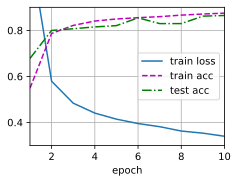

In [9]:
#对模型进⾏训练和测试
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 小结
* 暂退法在前向传播过程中，计算每⼀内部层的同时丢弃⼀些神经元。
* 暂退法可以避免过拟合，它通常与控制权重向量的维数和⼤⼩结合使⽤的。
* 暂退法将活性值h替换为具有期望值h的随机变量。
* 暂退法仅在训练期间使⽤。
